In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import netCDF4 as nc
import matplotlib as mpl

%load_ext autoreload
%autoreload 2

# Fitting function

In [2]:
def loglog_cooling_curve_fit(name, T, Lz, data_limits = (2,2000), fit_limits = (1,2000), plot_output = True, print_output = True):
    """ 
    Tool to produce fixed fraction impurity curves.
    They are fit with a 10 coefficient polynomial in log-log space (like AMJUEL does).
    The data used for the fit is trimmed to within lo_limit and hi_limit.
    This allows the fit to extrapolate past the data and gently take the curve to near-zero at the extremes.
    This will artificially reduce radiation at very high temperatures which makes it a bit more realistic since the nTau choice and even the fluid approximation break down in the core.

    Parameters
    ----------
        Te[eV] and Lz[W/m3] from cooling curve data (e.g. ADAS).
        data_limits: a tuple of the low and high temperature limit beyond which to trim the data
        fit_limits: a tuple of the low and high temperature limit beyond which the function will keep the same value as at the limit

    Returns
    -------
        Print of coefficients in a way that can be copy pasted into Hermes-3. The coefficients are for a polynomial that takes in log(T) and returns log(Lz)
        Plots showing fits
    """

    df = pd.DataFrame()
    df["T"] = T
    df["Lz"] = Lz
    df = df[df["T"] < 3000]  # Not interested in values above 3000

    T_hires = np.linspace(0, 3000, 100000)

    df["logT"] = np.log(df["T"])
    logT_hires = np.log(T_hires)
    df["logLz"] = np.log(df["Lz"])

    dftrim = df[(df["T"] > data_limits[0]) & (df["T"] < data_limits[1])]

    coeffs = np.polyfit(dftrim["logT"], dftrim["logLz"], deg = 10)[::-1]    # polyfit gives coeffs in opposite order to what polynomial needs 
    fit_func = np.polynomial.polynomial.Polynomial(coeffs)
    logLz_fit = [fit_func(x) for x in logT_hires]
    Lz_fit = np.exp(logLz_fit)

    fit_lo_limit_index = np.argmin(np.abs(T_hires - fit_limits[0]))
    fit_hi_limit_index = np.argmin(np.abs(T_hires - fit_limits[1]))
    Lz_lo = Lz_fit[fit_lo_limit_index]
    Lz_hi = Lz_fit[fit_hi_limit_index]

    Lz_fit_trim = np.where(T_hires > fit_limits[0], Lz_fit, Lz_lo)
    Lz_fit_trim = np.where(T_hires < fit_limits[1], Lz_fit_trim, Lz_hi)

    if plot_output is True:
        fig, axes = plt.subplots(3,1, figsize=(3*3, 8), dpi = 120)
        fig.subplots_adjust(hspace=0.3)
        fig.suptitle(name)
        for ax in axes:
            ax.plot(T_hires, Lz_fit_trim, label = "fit", c = "darkorange", lw = 2, ls = "-")
            ax.plot(df["T"], df["Lz"], label = "All data", marker = "x", lw = 0, c = "grey", ms = 4)
            ax.plot(dftrim["T"], dftrim["Lz"], label = "Utilised data", marker = "o", lw = 0, c = "navy", ms = 4)
            
            ax.legend(loc="upper right", bbox_to_anchor=(1.25,1))
            ax.grid(alpha = 0.3)

        ax = axes[0]

        for i, label in enumerate(["Full range", "0-200eV", "0-3eV"]):
            axes[i].set_title(label, loc="right")
            if i == 2: axes[i].set_xlabel("T [eV]") 
            axes[i].set_ylabel("Lz [W/m3]")

        axes[1].set_xlim(0,200)
        axes[2].set_xlim(0,3)
        axes[2].set_yscale("log")
        
    return {"coeffs":coeffs, "limit_values":(Lz_lo, Lz_hi), "fit_limits":fit_limits}

def make_hermes_rate(coeffs, limit_values, fit_limits):
    print("Hermes-3 copy-paste coefficients-------------------------")

    print(f""" 
        if (Te >= {fit_limits[0]} and Te <= {fit_limits[1]}) {{
        log_out = log_out""" )
    for i, x in enumerate(coeffs):
        if i == len(coeffs)-1:
            print(f"        {x:+.8e} * pow(logT, {i});")  # Semicolon at end
        else:
            print(f"        {x:+.8e} * pow(logT, {i})")
        
    print(f"""        return exp(log_out);""")
    print(f"""
    }} else if (Te < {fit_limits[0]}) {{
        return {limit_values[0]:.8e};   
    }} else {{
        return {limit_values[1]:.8e};
    }}
    """)

def get_Lz_rate(Te, coeffs, limit_values, fit_limits):
            
    logT = np.log(Te)
    log_out = 0

    if Te >= fit_limits[0] and Te <= fit_limits[1]:
        log_out = log_out          \
        +(coeffs[0]) * pow(logT, 0) \
        +(coeffs[1]) * pow(logT, 1) \
        +(coeffs[2]) * pow(logT, 2) \
        +(coeffs[3]) * pow(logT, 3) \
        +(coeffs[4]) * pow(logT, 4) \
        +(coeffs[5]) * pow(logT, 5) \
        +(coeffs[6]) * pow(logT, 6) \
        +(coeffs[7]) * pow(logT, 7) \
        +(coeffs[8]) * pow(logT, 8) \
        +(coeffs[9]) * pow(logT, 9) \
        +(coeffs[10]) * pow(logT, 10) 
        return np.exp(log_out)

    elif Te < fit_limits[0]:
        return limit_values[0]

    else:
        return limit_values[1]

# IO

In [6]:
# rates = pd.read_csv(os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\Lot 2\Cooling curves\Ar_0.5ms_DM.csv")).astype(float)
# rates = rates.set_index("T")
# rates.columns = ["T", "david"]


def RyokoArgon(T):
    answer = 0
    if T >= 1.5 and T<= 100:
        answer = -4.9692e-48*T**10 + 2.8025e-45*T**9 -6.7148e-43*T**8 + 8.8636e-41*T**7 -6.9642e-39*T**6 +3.2559e-37*T**5 -8.3410e-36*T**4 +8.6011e-35*T**3 +1.9958e-34*T**2 + 4.9864e-34*T -9.9412e-34
    elif T >= 1.0 and T< 1.5:
        answer = 2.5E-35/(1.5-1.0)*(T-1.0)
    else:
        answer = 0
    return answer

# rates["ryoko"] = rates["T"].apply(RyokoArgon)

# rates = rates[(rates["david"] != 0) & (rates["T"]<2000)].copy()    # Get rid of zeros
# rates["logT"] = np.log(rates["T"])

def HutchinsonCarbon(Te):

    return 2e-31*pow(Te/10., 3) / (1. + pow(Te/10., 4.5))

HutchinsonCarbon(5)

2.3941907191880164e-32

### Load radas

In [7]:
radas_datasets = dict()
radas_datasets["argon"] = nc.Dataset(os.path.join(onedrive_path, r"Project\BOUT-hermes-dev\new_cooling_curves\radas_output\argon\output\argon.nc"))
radas_datasets["nitrogen"] = nc.Dataset(os.path.join(onedrive_path, r"Project\BOUT-hermes-dev\new_cooling_curves\radas_output\nitrogen\output\nitrogen.nc"))
radas_datasets["neon"] = nc.Dataset(os.path.join(onedrive_path, r"Project\BOUT-hermes-dev\new_cooling_curves\radas_output\neon\output\neon.nc"))
radas_datasets["carbon"] = nc.Dataset(os.path.join(onedrive_path, r"Project\BOUT-hermes-dev\new_cooling_curves\radas_output\carbon\output\carbon.nc"))

## Plot rates

# Argon

In [9]:
fits = dict()

Ne is [1.e+20]
Taus are [0.5 1.0]
{'coeffs': array([-8.45410692e+01,  1.57727040e+01, -1.54264859e+01,  1.49409902e+01,
       -1.04815112e+01,  5.00924594e+00, -1.60029106e+00,  3.29455609e-01,
       -4.14036827e-02,  2.87063206e-03, -8.38888001e-05]), 'limit_values': (1.9535341256216753e-35, 1.2264960044660352e-32), 'fit_limits': (1.5, 1500)}
Hermes-3 copy-paste coefficients-------------------------
 
        if (Te >= 1.5 and Te <= 1500) {
        log_out = log_out
        -8.45410692e+01 * pow(logT, 0)
        +1.57727040e+01 * pow(logT, 1)
        -1.54264859e+01 * pow(logT, 2)
        +1.49409902e+01 * pow(logT, 3)
        -1.04815112e+01 * pow(logT, 4)
        +5.00924594e+00 * pow(logT, 5)
        -1.60029106e+00 * pow(logT, 6)
        +3.29455609e-01 * pow(logT, 7)
        -4.14036827e-02 * pow(logT, 8)
        +2.87063206e-03 * pow(logT, 9)
        -8.38888001e-05 * pow(logT, 10);
        return exp(log_out);

    } else if (Te < 1.5) {
        return 1.95353413e-35;   
    

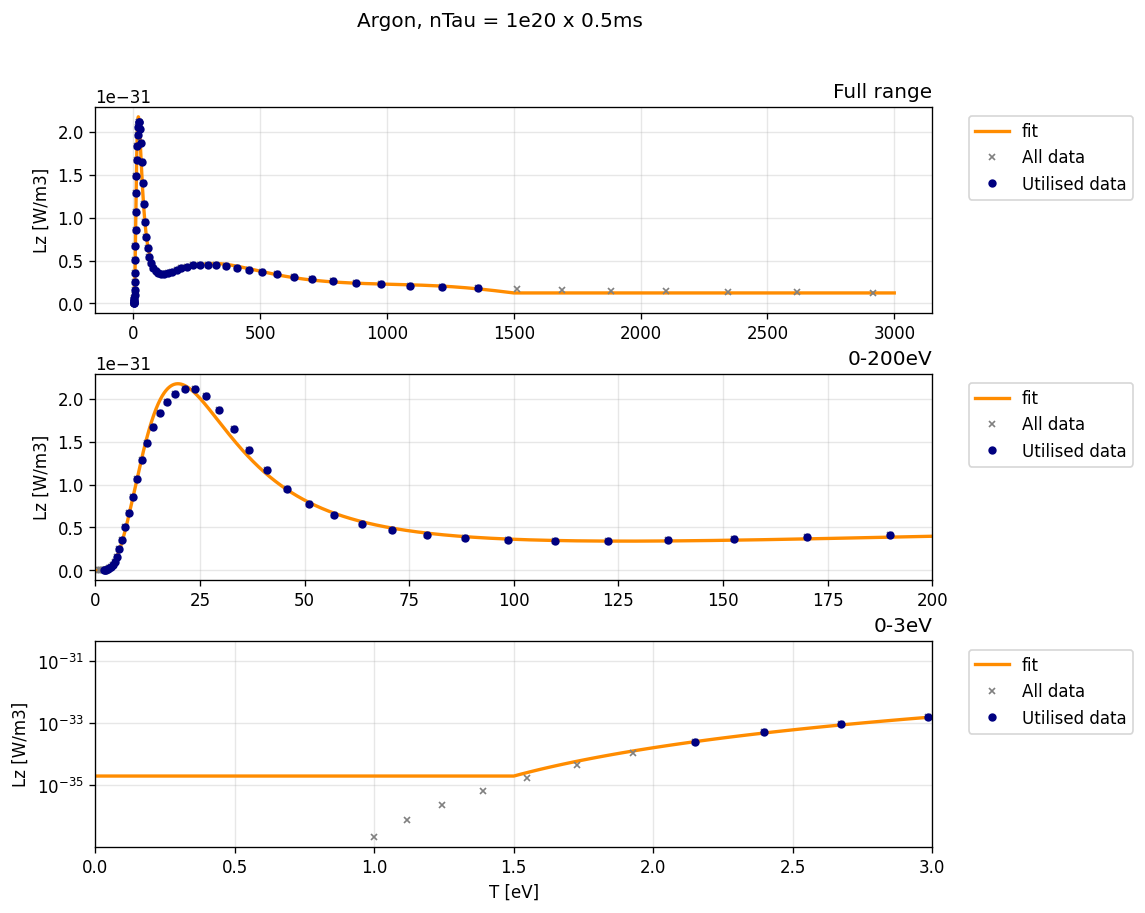

In [14]:
species = "argon"

d = radas_datasets[species]
Lz_all = d["noncoronal_electron_emission_prefactor"][:].squeeze()
Te = d["electron_temperature"][:]
Ne = d["electron_density"][:]
Nn = d["neutral_density"][:]
ntau = d["ne_tau"][:].squeeze()    # in m-3 s
tau = ntau / Ne * 1e3    # now in ms
print(f"Ne is {Ne}")
print(f"Taus are {tau}")

radas = pd.DataFrame()
radas["Te"] = Te
for i, t in enumerate(tau):
    radas[t] = Lz_all[:, i]

name = "ar"
fits[name] = loglog_cooling_curve_fit("Argon, nTau = 1e20 x 0.5ms", radas["Te"].values, radas[0.5].values, data_limits=(2,1500), fit_limits=(1.5,1500))
print(fits[name])
make_hermes_rate(fits[name]["coeffs"], fits[name]["limit_values"], fits[name]["fit_limits"])


# Neon

Ne is [1.e+20]
Taus are [0.5 1.0]
{'coeffs': array([-8.21475117e+01,  1.28929854e+01, -4.74266288e+01,  7.45222324e+01,
       -5.75710722e+01,  2.57375965e+01, -7.12758563e+00,  1.24287546e+00,
       -1.32943407e-01,  7.97368445e-03, -2.05487897e-04]), 'limit_values': (6.353041125938587e-36, 1.1789462765743393e-32), 'fit_limits': (2, 1000)}
Hermes-3 copy-paste coefficients-------------------------
 
        if (Te >= 2 and Te <= 1000) {
        log_out = log_out
        -8.21475117e+01 * pow(logT, 0)
        +1.28929854e+01 * pow(logT, 1)
        -4.74266288e+01 * pow(logT, 2)
        +7.45222324e+01 * pow(logT, 3)
        -5.75710722e+01 * pow(logT, 4)
        +2.57375965e+01 * pow(logT, 5)
        -7.12758563e+00 * pow(logT, 6)
        +1.24287546e+00 * pow(logT, 7)
        -1.32943407e-01 * pow(logT, 8)
        +7.97368445e-03 * pow(logT, 9)
        -2.05487897e-04 * pow(logT, 10);
        return exp(log_out);

    } else if (Te < 2) {
        return 6.35304113e-36;   
    } else 

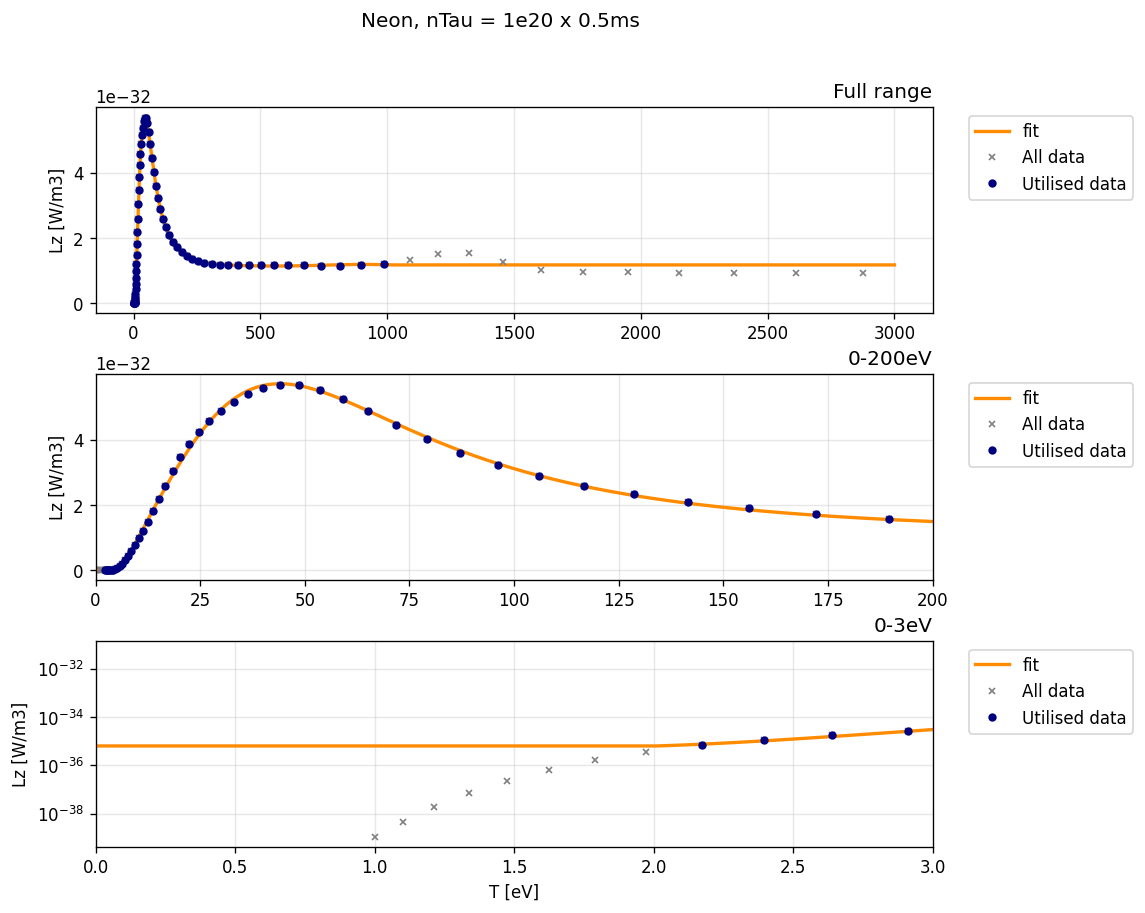

In [15]:
species = "neon"

d = radas_datasets[species]
Lz_all = d["noncoronal_electron_emission_prefactor"][:].squeeze()
Te = d["electron_temperature"][:]
Ne = d["electron_density"][:]
Nn = d["neutral_density"][:]
ntau = d["ne_tau"][:].squeeze()    # in m-3 s
tau = ntau / Ne * 1e3    # now in ms
print(f"Ne is {Ne}")
print(f"Taus are {tau}")

radas = pd.DataFrame()
radas["Te"] = Te
for i, t in enumerate(tau):
    radas[t] = Lz_all[:, i]

name = "ne"
fits[name] = loglog_cooling_curve_fit("Neon, nTau = 1e20 x 0.5ms", radas["Te"].values, radas[0.5].values, data_limits=(2,1000), fit_limits=(2,1000))
print(fits[name])
make_hermes_rate(fits[name]["coeffs"], fits[name]["limit_values"], fits[name]["fit_limits"])

# Nitrogen

Ne is [1.e+20]
Taus are [0.5 1.0]
{'coeffs': array([-5.01649970e+01, -1.35749723e+02,  2.73509607e+02, -2.92109992e+02,
        1.90120639e+02, -7.95164870e+01,  2.17762218e+01, -3.88334991e+00,
        4.34730098e-01, -2.77683605e-02,  7.72720421e-04]), 'limit_values': (4.348353794071008e-34, 8.110961814479663e-33), 'fit_limits': (2, 500)}
Hermes-3 copy-paste coefficients-------------------------
 
        if (Te >= 2 and Te <= 500) {
        log_out = log_out
        -5.01649970e+01 * pow(logT, 0)
        -1.35749723e+02 * pow(logT, 1)
        +2.73509607e+02 * pow(logT, 2)
        -2.92109992e+02 * pow(logT, 3)
        +1.90120639e+02 * pow(logT, 4)
        -7.95164870e+01 * pow(logT, 5)
        +2.17762218e+01 * pow(logT, 6)
        -3.88334991e+00 * pow(logT, 7)
        +4.34730098e-01 * pow(logT, 8)
        -2.77683605e-02 * pow(logT, 9)
        +7.72720421e-04 * pow(logT, 10);
        return exp(log_out);

    } else if (Te < 2) {
        return 4.34835379e-34;   
    } else {
 

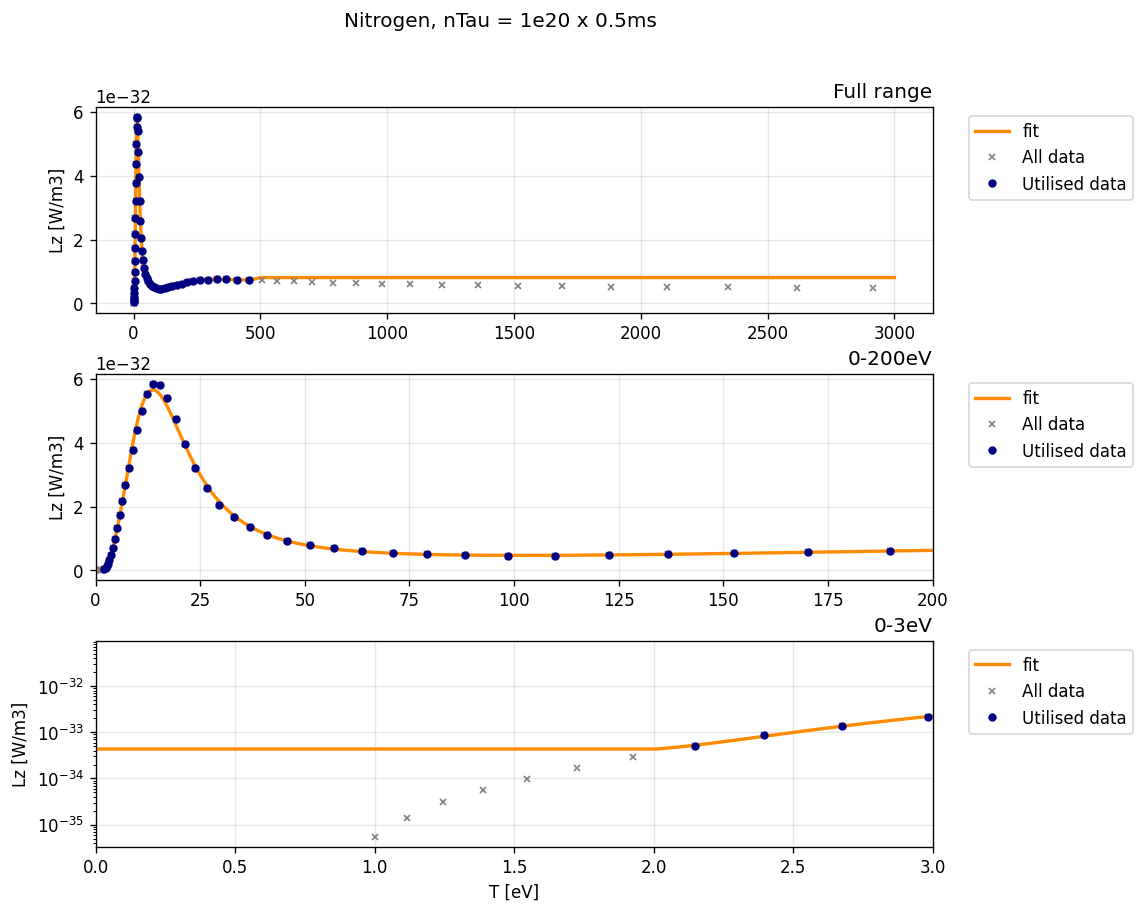

In [16]:
species = "nitrogen"

d = radas_datasets[species]
Lz_all = d["noncoronal_electron_emission_prefactor"][:].squeeze()
Te = d["electron_temperature"][:]
Ne = d["electron_density"][:]
Nn = d["neutral_density"][:]
ntau = d["ne_tau"][:].squeeze()    # in m-3 s
tau = ntau / Ne * 1e3    # now in ms
print(f"Ne is {Ne}")
print(f"Taus are {tau}")

radas = pd.DataFrame()
radas["Te"] = Te
for i, t in enumerate(tau):
    radas[t] = Lz_all[:, i]

name = "n"
fits[name] = loglog_cooling_curve_fit("Nitrogen, nTau = 1e20 x 0.5ms", radas["Te"].values, radas[0.5].values, data_limits=(2,500), fit_limits=(2,500))
print(fits[name])
make_hermes_rate(fits[name]["coeffs"], fits[name]["limit_values"], fits[name]["fit_limits"])


# Carbon

Ne is [1.e+20]
Taus are [0.5 1.0]
{'coeffs': array([-7.87837896e+01,  1.55326376e+00,  1.65898194e+01, -3.23804546e+01,
        3.12784663e+01, -1.74826039e+01,  5.91393245e+00, -1.22974105e+00,
        1.54004499e-01, -1.06797106e-02,  3.15657594e-04]), 'limit_values': (6.006239277360004e-35, 4.530577071106137e-33), 'fit_limits': (1, 500)}
Hermes-3 copy-paste coefficients-------------------------
 
        if (Te >= 1 and Te <= 500) {
        log_out = log_out
        -7.87837896e+01 * pow(logT, 0)
        +1.55326376e+00 * pow(logT, 1)
        +1.65898194e+01 * pow(logT, 2)
        -3.23804546e+01 * pow(logT, 3)
        +3.12784663e+01 * pow(logT, 4)
        -1.74826039e+01 * pow(logT, 5)
        +5.91393245e+00 * pow(logT, 6)
        -1.22974105e+00 * pow(logT, 7)
        +1.54004499e-01 * pow(logT, 8)
        -1.06797106e-02 * pow(logT, 9)
        +3.15657594e-04 * pow(logT, 10);
        return exp(log_out);

    } else if (Te < 1) {
        return 6.00623928e-35;   
    } else {
 

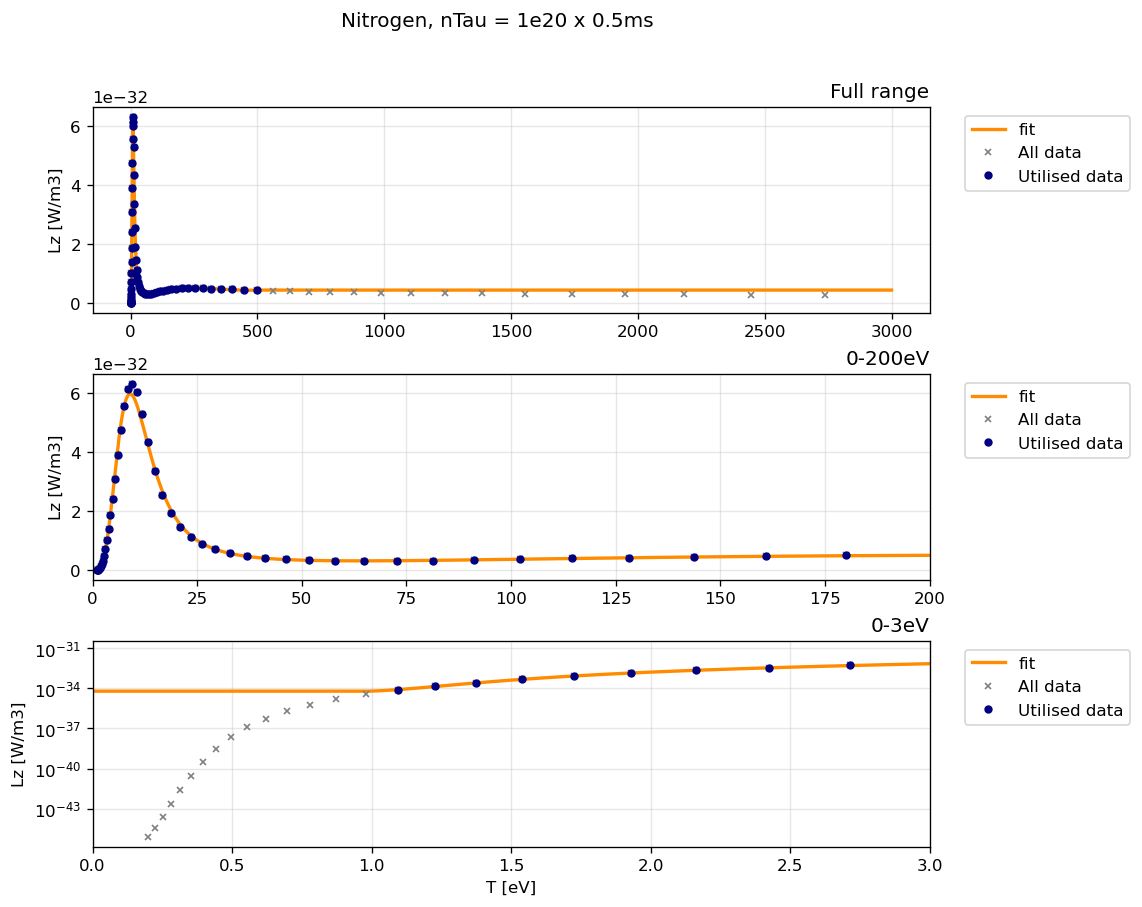

In [10]:
species = "carbon"

d = radas_datasets[species]
Lz_all = d["noncoronal_electron_emission_prefactor"][:].squeeze()
Te = d["electron_temperature"][:]
Ne = d["electron_density"][:]
Nn = d["neutral_density"][:]
ntau = d["ne_tau"][:].squeeze()    # in m-3 s
tau = ntau / Ne * 1e3    # now in ms
print(f"Ne is {Ne}")
print(f"Taus are {tau}")

radas = pd.DataFrame()
radas["Te"] = Te
for i, t in enumerate(tau):
    radas[t] = Lz_all[:, i]

name = "c"
fits[name] = loglog_cooling_curve_fit("Nitrogen, nTau = 1e20 x 0.5ms", radas["Te"].values, radas[0.5].values, data_limits=(1,500), fit_limits=(1,500))
print(fits[name])
make_hermes_rate(fits[name]["coeffs"], fits[name]["limit_values"], fits[name]["fit_limits"])


# Check implementation

In [19]:
case = Load.case_1D(r"C:\Users\mikek\OneDrive\Project\collab\tech\cases\step1d_cooling_curve_test\t1b-ar_ne_n_c_hc")

c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


************
ar
Error: 0.027432487460735264
************
ne
Error: 5.32512420436715e-05
************
n
Error: -0.005268748712417056
************
c
Error: 0.02034180201515954


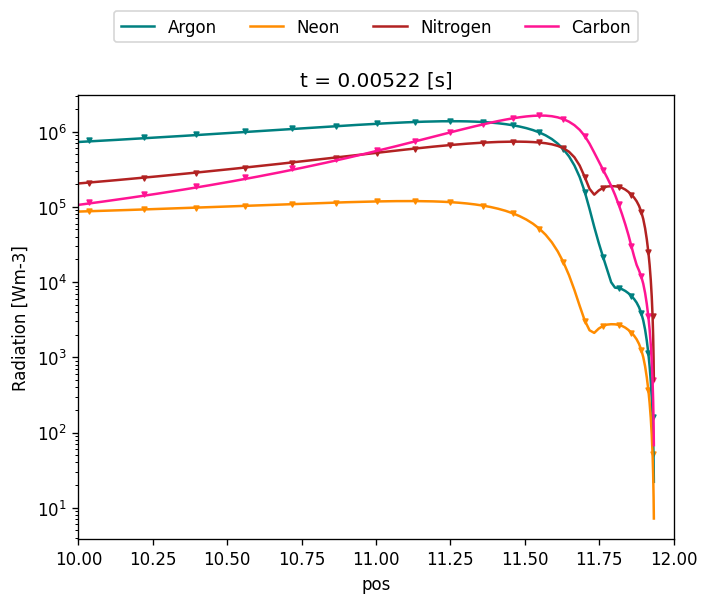

In [29]:
ds = case.ds.isel(t=-1, pos = slice(2,-2))
Te = ds["Te"].values
Ne = ds["Ne"].values
pos = ds["pos"].values

fig, ax = plt.subplots(dpi = 120)

colors = ["teal", "darkorange", "firebrick", "deeppink"]

species_names = dict(
    ar = "Argon", 
    ne = "Neon", 
    n = "Nitrogen", 
    c = "Carbon"
    )

for i, species in enumerate(species_names):
    
    
    ds[f"R{species}"].plot(ax = ax, label = species_names[species], color = colors[i])
    
    intended = [get_Lz_rate(x, fits[species]["coeffs"],  fits[species]["limit_values"],  fits[species]["fit_limits"]) for x in Te]
    intended = intended * Ne * (Ne * 0.002)
    ax.scatter(pos[::4], intended[::4], color = colors[i], s=8, marker = "v")
    
    print(f"************")
    print(species)
    print(f"Error: {(intended.sum() - ds[f'R{species}'].sum()) / intended.sum()}")
    

ax.set_yscale("log")
ax.set_ylabel("Radiation [Wm-3]")
ax.set_xlim(10,12)

ax.legend(ncols = 4, bbox_to_anchor=(0.5,1.1), loc = "lower center")
# styles = plt.style.available


# with plt.style.context('stylename'):
#     make_a_plot()

# Compare old rates against new
- Old N, Ne and Ar rates were originally fitted for use in the DLS model (https://iopscience.iop.org/article/10.1088/1741-4326/ac7a4c/meta)
- N came from Lipschultz 2016 and Ne/Ar came from ADAS using 0.1ms/1e20m-3
- These were limited and went to zero at low temps causing issues with the solver
- Old C rate was taken from Hutchinson (I.H.Hutchinson Nucl. Fusion 34 (10) 1337 - 1348 (1994)) and its origin isn't really referenced other than being an "approximation".

In [ ]:
#Nitrogen based cooling curve used in Lipschultz 2016
def LfuncN(T):
   answer = 0
   if T >= 1 and T<= 80:
       answer = 5.9E-34*(T-1)**(0.5)
       answer = answer*(80-T)
       answer = answer/(1+(3.1E-3)*(T-1)**2)
   else:
       answer = 0
   return answer


#Ne based cooling curve produced by Matlab polynominal curve fitting "polyval" (Ryoko 2020 Nov)
def LfuncNe(T):    
    answer = 0
    if T >= 3 and T<= 100:
        answer = -2.0385E-40*T**5 + 5.4824E-38*T**4 -5.1190E-36*T**3 + 1.7347E-34*T**2 -3.4151E-34*T -3.2798E-34
    elif T >=2 and T < 3:
        answer = (8.0-1.0)*1.0E-35/(3.0-2.0)*(T-2.0)+1.0E-35
    elif T >=1 and T < 2:
        answer = 1.0E-35/(2.0-1.0)*(T-1.0)
    else:
        answer = 0
    return answer

#Ar based cooling curve produced by Matlab polynominal curve fitting "polyval" (Ryoko 2020 Nov)
def LfuncAr(T):
    answer = 0
    if T >= 1.5 and T<= 100:
        answer = -4.9692e-48*T**10 + 2.8025e-45*T**9 -6.7148e-43*T**8 + 8.8636e-41*T**7 -6.9642e-39*T**6 +3.2559e-37*T**5 -8.3410e-36*T**4 +8.6011e-35*T**3 +1.9958e-34*T**2 + 4.9864e-34*T -9.9412e-34
    elif T >= 1.0 and T< 1.5:
        answer = 2.5E-35/(1.5-1.0)*(T-1.0)
    else:
        answer = 0
    return answer


def HutchinsonCarbon(Te):

    return 2e-31*pow(Te/10., 3) / (1. + pow(Te/10., 4.5))



Text(0.5, 1.0, '0-3eV')

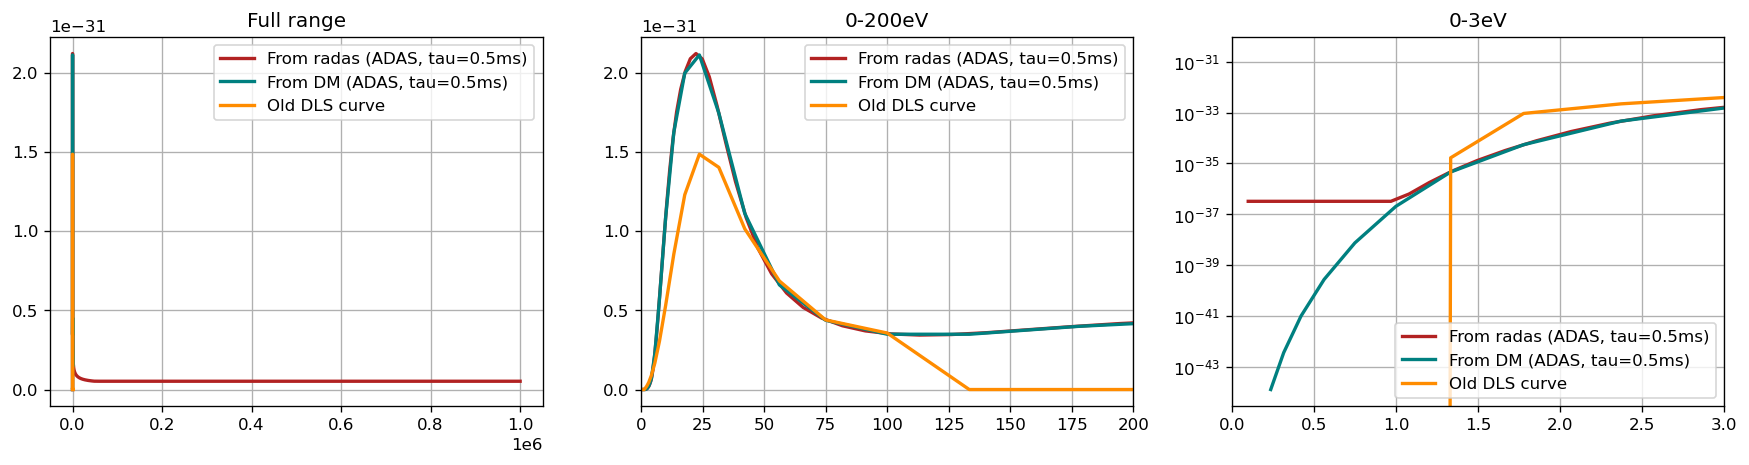

In [7]:
Te = np.linspace(0.1,500,200)


fig, axes = plt.subplots(1, 4, dpi = 100, figsize = (16,4))


axes[0].plot(Te,
    [LfuncAr(x) for x in Te], 
     label = "Original (ADAS 0.1x1e20)")
axes[0].plot(Te, 
        [get_Lz_rate(x, fits["ar"]["coeffs"], fits["ar"]["limit_values"], fits["ar"]["fit_limits"]) for x in Te], 
        label = "ADAS argon @ 0.5 x 1e20 [ms][m-3]")

axes[1].plot(Te,
    [LfuncNe(x) for x in Te], 
     label = "Original")
axes[1].plot(Te, 
        [get_Lz_rate(x, fits["ne"]["coeffs"], fits["ne"]["limit_values"], fits["ne"]["fit_limits"]) for x in Te], 
        label = "ADAS neon @ 0.5 x 1e20 [ms][m-3]")

axes[2].plot(Te,
    [LfuncN(x) for x in Te], 
     label = "Original (Lipschultz 2016)")
axes[2].plot(Te, 
        [get_Lz_rate(x, fits["n"]["coeffs"], fits["n"]["limit_values"], fits["n"]["fit_limits"]) for x in Te], 
        label = "ADAS nitrogen @ 0.5 x 1e20 [ms][m-3]")

axes[3].plot(Te,
    [HutchinsonCarbon(x) for x in Te], 
     label = "Original (Hutchinson)")
axes[3].plot(Te, 
        [get_Lz_rate(x, fits["c"]["coeffs"], fits["c"]["limit_values"], fits["c"]["fit_limits"]) for x in Te], 
        label = "ADAS carbon @ 0.5 x 1e20 [ms][m-3]")

titles = ["Argon", "Neon", "Nitrogen", "Carbon"]
for i,ax in enumerate(axes):
        ax.set_title(titles[i])
        ax.set_xlabel("T [eV]")
        ax.set_ylabel("Lz [Wm-3]")
        ax.grid(c = "k", lw = 0.5, alpha = 0.2)
        ax.legend(fontsize = 7)
        

# ax.legend()
# ax.grid()
# ax.set_xlabel("Temp [eV]")
# ax.set_ylabel("Radiation [Wm-3]")

### Carbon

Text(0, 0.5, 'Radiation [Wm-3]')

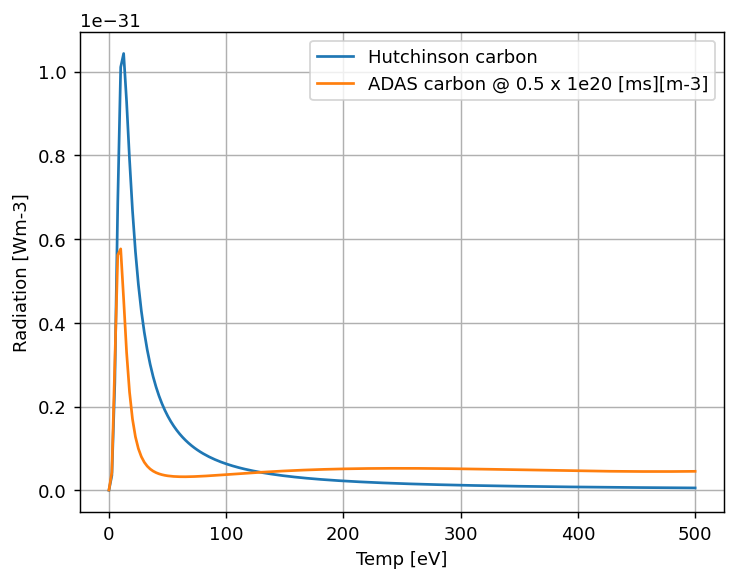

In [20]:
Te = np.linspace(0.1,500,200)

old_c = [HutchinsonCarbon(x) for x in Te]
new_c = [get_Lz_rate(x, fits["c"]["coeffs"], fits["c"]["limit_values"], fits["c"]["fit_limits"]) for x in Te]

fig, ax = plt.subplots(dpi = 130)

ax.plot(Te, old_c, label = "Hutchinson carbon")
ax.plot(Te, new_c, label = "ADAS carbon @ 0.5 x 1e20 [ms][m-3]")
ax.legend()
ax.grid()
ax.set_xlabel("Temp [eV]")
ax.set_ylabel("Radiation [Wm-3]")

In [92]:
ds.options["ar"]["fraction"]

0.002